# Лабораторные   работы   1-2 
# «Разработка   рекомендательного   сервиса» 

Выполнил: xxx xxx xxxович, Группа xxx, вариант 5

Цель работы:
 1. Изучить возможности процедур работы с данными с использованием языка разработки Python 
 2. Разработать элементы функций рекомендательного сервиса на основе метода коллаборативной фильтрации 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#pretty plots
import seaborn as sns
plt.style.use('seaborn')

#for good visualisation in notebook
from IPython.core.display import display, HTML, Markdown

# Progress bar for a “for” loop
from tqdm.notebook import tqdm

## Первичное знакомство с данными

### Metadata
- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714   https://www.amazon.com/dp/0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review, e.g. 2/3
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

In [2]:
df = pd.read_csv("datasets/05.Amazon_Automotive/05.Amazon Automotive.csv")
display(df.head())
display(df.shape)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3F73SC1LY51OO,B00002243X,Alan Montgomery,"[4, 4]",I needed a set of jumper cables for my new car...,5,Work Well - Should Have Bought Longer Ones,1313539200,"08 17, 2011"
1,A20S66SKYXULG2,B00002243X,alphonse,"[1, 1]","These long cables work fine for my truck, but ...",4,Okay long cables,1315094400,"09 4, 2011"
2,A2I8LFSN2IS5EO,B00002243X,Chris,"[0, 0]",Can't comment much on these since they have no...,5,Looks and feels heavy Duty,1374710400,"07 25, 2013"
3,A3GT2EWQSO45ZG,B00002243X,DeusEx,"[19, 19]",I absolutley love Amazon!!! For the price of ...,5,Excellent choice for Jumper Cables!!!,1292889600,"12 21, 2010"
4,A3ESWJPAVRPWB4,B00002243X,E. Hernandez,"[0, 0]",I purchased the 12' feet long cable set and th...,5,"Excellent, High Quality Starter Cables",1341360000,"07 4, 2012"


(20473, 9)

In [3]:
for col in df.columns:
    display(HTML('<h1 style="background-color:#FFAA00;">' + col + '</h1>'))
    display(df[col].describe())

count              20473
unique              2928
top       A2V1J3JT5OOZFO
freq                  51
Name: reviewerID, dtype: object

count          20473
unique          1835
top       B000CITK8S
freq             169
Name: asin, dtype: object

count               20260
unique               2788
top       Amazon Customer
freq                  173
Name: reviewerName, dtype: object

count      20473
unique       380
top       [0, 0]
freq       12844
Name: helpful, dtype: object

count                                                 20467
unique                                                20467
top       I separated these into several small sandwich ...
freq                                                      1
Name: reviewText, dtype: object

count    20473.000000
mean         4.471841
std          0.940337
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: overall, dtype: float64

count          20473
unique         17225
top       Five Stars
freq              95
Name: summary, dtype: object

count    2.047300e+04
mean     1.365018e+09
std      3.621266e+07
min      1.121386e+09
25%      1.354838e+09
50%      1.373414e+09
75%      1.390435e+09
max      1.405901e+09
Name: unixReviewTime, dtype: float64

count          20473
unique          1855
top       07 8, 2014
freq              82
Name: reviewTime, dtype: object

---
Для дальнейшей работы нам потребуются только "reviewerID", "asin" и "overall", причём, переименуем их сразу в "user", "item" и "rating"

In [4]:
df = df[["reviewerID", "asin", "overall"]]
df.columns = ["user", "item", "rating"]
df.head()

,user,item,rating
0,A3F73SC1LY51OO,B00002243X,5
1,A20S66SKYXULG2,B00002243X,4
2,A2I8LFSN2IS5EO,B00002243X,5
3,A3GT2EWQSO45ZG,B00002243X,5
4,A3ESWJPAVRPWB4,B00002243X,5


In [5]:
def short_description_of_filling(rankings: pd.DataFrame):
    n_users = len(rankings["user"].unique())
    n_items = len(rankings["item"].unique())
    n_ratings = len(rankings)
    print ("Унакальных Пользователей:", n_users)
    print ("Унакальных Товаров:", n_items)
    print ("Выставленных оценок:", n_ratings)
    # Расчет доли заполнения оценками
    print("Размер матрицы: {} x {}, Ячеек в матрице: {}, Будет заполнено: {:.3%}".format (n_users, n_items, n_users * n_items, n_ratings / (n_users * n_items)))

In [6]:
short_description_of_filling(df)

Унакальных Пользователей: 2928
Унакальных Товаров: 1835
Выставленных оценок: 20473
Размер матрицы: 2928 x 1835, Ячеек в матрице: 5372880, Будет заполнено: 0.381%


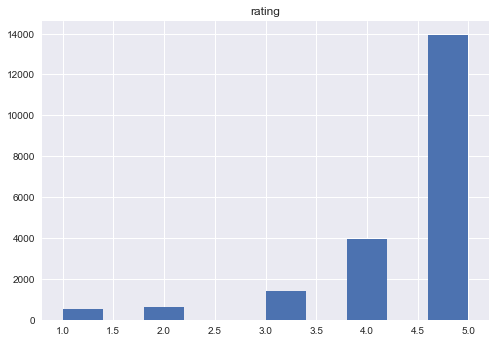

In [7]:
df.hist()
plt.show()

Большинство из выставленных оценок - это "5". Плохие оценки люди выставляют очень редко. Также замечено, что не существует оценок "0".

## Выбор части исходной таблицы с пользователями, имеющими наибольшее кол-во оценок

Изначальная заполненность таблицы очень маленькая. Из всех пользователей и фильмов выберем **n_users** пользователей с наибольшим кол-вом отзывов и из них **n_items** объектов с наибольшим кол-вом отзывов.

In [8]:
nUsers = 20
nItems = 20

mostActiveUsers = df["user"].value_counts().head(nUsers).index
dfNUsers = df[df["user"].isin(mostActiveUsers)]
mostActiveItems = dfNUsers["item"].value_counts().head(nItems).index
rankings = dfNUsers[dfNUsers["item"].isin(mostActiveItems)].reset_index(drop=True)

print("Было", len(df), "элементов в DataFrame")
print("Стало", len(rankings), "элементов в DataFrame")
print("-"*40)
display(Markdown("**Полученная таблица с наибольшим количеством отзывов:**"))
# display(rankings.head(3))
short_description_of_filling(rankings)

Было 20473 элементов в DataFrame
Стало 71 элементов в DataFrame
----------------------------------------


**Полученная таблица с наибольшим количеством отзывов:**

Унакальных Пользователей: 18
Унакальных Товаров: 20
Выставленных оценок: 71
Размер матрицы: 18 x 20, Ячеек в матрице: 360, Будет заполнено: 19.722%


## Получение списка уникальных пользователей и товаров

In [9]:
userUniqList=rankings["user"].unique().tolist()
userUniqList.sort()
itemUniqList=rankings["item"].unique().tolist()
itemUniqList.sort()

## Формирование матрицы R

In [10]:
# Создание матрицы нужной размерности
dataMatrix=np.zeros((len(userUniqList), len(itemUniqList)))

# Занесение оценок в матрицу
for i in tqdm(rankings.index) :
    line = rankings.loc[i, :]
    userName = line["user"]
    itemName = line["item"]
    rate = float(line["rating"])
    # получить индекс ИД_пользователя/предмета в списке уникальных ИД
    indexForUser = userUniqList.index(userName)
    indexForItem = itemUniqList.index(itemName)
    # Внести оценку
    dataMatrix[indexForUser, indexForItem] = rate

In [11]:
# Расчет доли заполнения оценками
print("Размер матрицы {} x {}, Элементов {}, Будет заполнено {:%}".format (
    dataMatrix.shape[0], dataMatrix.shape[1],
    dataMatrix.shape[0] * dataMatrix.shape[1],
    len (rankings)/(dataMatrix.shape[0] * dataMatrix.shape[1])))

Размер матрицы 18 x 20, Элементов 360, Будет заполнено 19.722222%


## Вывод матрицы R в графическом виде

In [12]:
# Вывод матрицы R в графическом виде
from matplotlib import cm

def visualizeR(dataMatrix, xlabel, ylabel, xlabelsList=None, ylabelsList=None, isAddTicks=False, autoFigsize=True):

    # создание своей цветовой карты, с разделением на 5 участков по количеству оценок
    myColorMap = cm.get_cmap('viridis', 5)

    # создание полотна размером HхW
    if autoFigsize:
        plt.figure(figsize=(9, 6.5))

    # отрисовка матрицы, применив цветовую карту
    plt.imshow(dataMatrix, myColorMap)

    # добавление названия осей
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


    # добавление подписи осей
    if isAddTicks:
        plt.xticks( ticks=np.arange(len(xlabelsList)),
                    labels=xlabelsList,
                    rotation=20)

        plt.yticks( ticks=np.arange(len(ylabelsList)),
                    labels=ylabelsList,
                    rotation=0)
    else:
        if(xlabelsList is not None):
            plt.xticks(ticks=np.arange(0,len (xlabelsList)), labels=[])
        else:
            plt.xticks(ticks=[], labels=[])
        if(xlabelsList is not None):
            plt.yticks(ticks=np.arange(0,len (ylabelsList)), labels=[])
        else:
            plt.yticks(ticks=[], labels=[])

    # добавление цветовой полосы
    plt.colorbar()

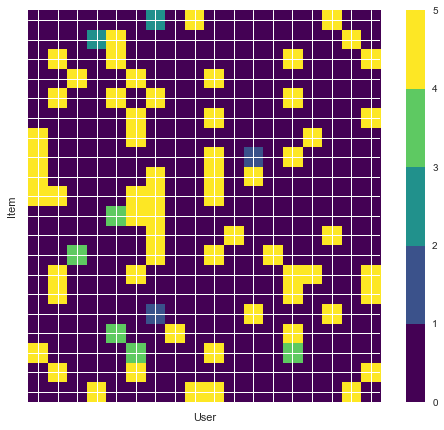

In [13]:
# visualizeR(dataMatrix, "Item", "User", itemUniqList, userUniqList)

# Транспонированная матрица R
plt.figure(figsize=(9, 7.2))
visualizeR(dataMatrix.T, "User", "Item", userUniqList, itemUniqList, autoFigsize=False)

# Отыскание похожих пользователей

В задании указывали, что функция схожести вычисляется только по тем объектам, которые оценили оба пользователя. Функция notUseZero позволяет учесть этот момент.

In [14]:
def notUseZero(x: np.array, y: np.array):
    if (type(x) is not np.ndarray or type(y) is not np.ndarray):
        x = np.array(x)
        y = np.array(y)
    else:
        x = x.copy()
        y = y.copy()
    y[x == 0] = 0
    x[y == 0] = 0
    return x, y

def test_notUseZero():
    x = [1, 2, 0, 0]
    y = [0, 3, 0, 1]
    xExpected = [0, 2, 0, 0]
    yExpected = [0, 3, 0, 0]
    xReceived, yReceived = notUseZero(x, y)
    assert (xExpected == xReceived).all(), "X failed.\n\tExpected: {}\n\tReceived: {}".format(xExpected, xReceived)
    assert (yExpected == yReceived).all(), "Y failed.\n\tExpected: {}\n\tReceived: {}".format(yExpected, yReceived)
    print("test_notUseZero выполнен успешно")

test_notUseZero()

test_notUseZero выполнен успешно


## Метрики

In [15]:
def euclideDistance(x: np.array, y: np.array):
    return sum((x - y)**2)**0.5

def manhattanDistance(x: np.array, y: np.array):
    return sum(abs(x - y))

def pearson(x: np.array, y: np.array):
    if ((np.max(x) == np.min(x)) or (np.max(y) == np.min(y))): # Один из векторов состоит только из одного значения
        return 0
    if (x == y).all():
        return 1
    return sum((x - x.mean()) * (y - y.mean())) / (sum(x**2 - x.mean()**2)**0.5 * sum(y**2 - y.mean()**2)**0.5)

def jaccardDistance(x: np.array, y: np.array):
    if (x == y).all():
        return 1
    return sum(np.minimum(x, y)) / sum(np.maximum(x, y))

def cosinusDistance(x: np.array, y: np.array):
    if (x == y).all():
        return 1
    xdoty = x.dot(y)
    if (np.isclose(xdoty, 0)):
        return 0
    return x.dot(y) / (np.linalg.norm(x) * np.linalg.norm(y))
 

def tests_distance():
    # Проверка, на нулевом векторе
    x = np.zeros(5)
    assert np.isclose(euclideDistance(x, x), 0), "euclideDistance, empty"
    assert np.isclose(manhattanDistance(x, x), 0), "manhattanDistance, empty"
    assert np.isclose(pearson(x, x), 0), "pearson, empty"
    assert np.isclose(jaccardDistance(x, x), 1), "jaccardDistance, empty"
    assert np.isclose(cosinusDistance(x, x), 1), "cosinusDistance, empty"
    
    # Теперь то же самое (вектор сам с сабой), но вектор не нулевой
    x = np.random.rand(5)
    assert np.isclose(euclideDistance(x, x), 0), "euclideDistance, вектор сам с сабой"
    assert np.isclose(manhattanDistance(x, x), 0), "manhattanDistance, вектор сам с сабой"
    assert np.isclose(pearson(x, x), 1), "pearson, вектор сам с сабой"
    assert np.isclose(jaccardDistance(x, x), 1), "jaccardDistance, вектор сам с сабой"
    assert np.isclose(cosinusDistance(x, x), 1), "cosinusDistance, вектор сам с сабой"
    
    
    x = np.array([1, 1])
    y = np.array([0, 0])
    assert np.isclose(euclideDistance(x, y), 2**0.5), "euclideDistance, x={}, y={}".format(x, y)
    assert np.isclose(manhattanDistance(x, y), 2), "manhattanDistance, x={}, y={}".format(x, y)
    assert np.isclose(pearson(x, y), 0), "pearson, x={}, y={}".format(x, y)
    assert np.isclose(jaccardDistance(x, y), 0), "jaccardDistance, x={}, y={}".format(x, y)
    assert np.isclose(cosinusDistance(x, y), 0), "cosinusDistance, x={}, y={}".format(x, y)
    
    x = np.array([0, 1])
    y = np.array([1, 0])
    assert np.isclose(euclideDistance(x, y), 2**0.5), "euclideDistance, x={}, y={}".format(x, y)
    assert np.isclose(manhattanDistance(x, y), 2), "manhattanDistance, x={}, y={}".format(x, y)
    assert np.isclose(pearson(x, y), -1), "pearson, x={}, y={}".format(x, y)
    assert np.isclose(jaccardDistance(x, y), 0), "jaccardDistance, x={}, y={}".format(x, y)
    assert np.isclose(cosinusDistance(x, y), 0), "cosinusDistance, x={}, y={}".format(x, y)
    
    print("tests_distance выполнен успешно")
    
tests_distance()

tests_distance выполнен успешно


## Мера схожести sim
Мера схожести равна 0, если объекты не схожи, и положительному числу (желательно 1), если схожи. Соответственно, чем ближе sim к 0, тем менее похожи объекты.

Для меры Евклида и Манхэттенской меры сделали, как рекомендовали в notebook-примере. Для коэффициента корреляции Пирсона оставили, значение для положительной корреляции, для отрицательной - сделали sim=0. Для меры Жаккара можно ни чего не менять, так как у нас оценки положительные, то мера будет в диапазоне [0; 1]. Косинусная мера имеет 1, когда объекты совпадают; когда значения отрицательны, то сделали sim=0.

In [19]:
class Sim(object):
    
    def __init__(self, x: np.array, y: np.array):
        self._x, self._y = notUseZero(x, y)
        if ((self._x == 0).all() or (self._y == 0).all()): # В этом случае для всех способов sim будет 0
            self._sim = 0
        else : # Иначе придётся в дальнейшем вычислять
            self._sim = self.simCalculate(x, y)
        
    @staticmethod
    def simCalculate(x: np.array, y: np.array):
        raise "It's abstract method. You should override it"
      
    @property
    def sim(self):
        return self._sim
    

class EuclideSim(Sim):
    @staticmethod
    def simCalculate(x: np.array, y: np.array):
        return 1 / (1 + euclideDistance(x, y))
    
    
class ManhattanSim(Sim):
    @staticmethod
    def simCalculate(x: np.array, y: np.array):
        return 1 / (1 + manhattanDistance(x, y))


class PearsonSim(Sim):
    @staticmethod
    def simCalculate(x: np.array, y: np.array):
        s = pearson(x, y)
        s = s if s < 0 else 0
        return s

    
class JaccardSim(Sim):
    @staticmethod
    def simCalculate(x: np.array, y: np.array):
        return jaccardDistance(x, y)
        
class CosinusSim(Sim):
    @staticmethod
    def simCalculate(x: np.array, y: np.array):
        s = cosinusDistance(x, y)
        s = s if s < 0 else 0
        return s


## Получение матрицы RSim
Это будет квадратная, симметричная относительно главной диагонали таблица, в которой показаны sim для каждой пары сравниваемых субъектов/объектов. При этом, по диагонали будут нули (то есть, sim=0 для самого себя).

*(Это немного отличается от пошагового задания, но конечный результат будет одинаковым).*

In [115]:
def getRSim(dataMatrix, labels: list, SimClass):
    """
        dataMatrix: матрица, строками которой являются сравниваемые объекты
        labels: список имён сравниваемых объектов
    return:
        RSim: квадратная, симметричная относительно главной диагонали таблица, 
              в которой показаны sim для каждой пары сравниваемых объектов. При этом, по диагонали нули 
              (то есть, sim=0 для самого себя)
    """
    RSim = pd.DataFrame(0, columns=labels, index=labels)
    for i in range(len(labels) - 1):
        for j in range(i + 1, len(labels)):
            sim = SimClass(dataMatrix[i], dataMatrix[j])
            RSim.iloc[i, j] = sim.sim
    # Заполнили только для верхней части матрицы, теперь надо отразить относительно диагонали
    RSim = RSim + RSim.T
    return RSim

def exampleRSim():
    display(Markdown("**Пример RSim**"))
    dataMatrix = np.array([np.array([1, 0, 1]), np.array([1, 0, 1]), np.array([1, 0, 0]), np.array([5, 0, 0])])
    print("dataMatrix:")
    display(dataMatrix)
    labels = ["q", "w", "r", "t"]
    print("labels: {}".format(labels))
    print("SimClass: ManhattanSim")
    print("RSim:")
    display(getRSim(dataMatrix, labels, ManhattanSim))
    
exampleRSim()

**Пример RSim**

dataMatrix:


array([[1, 0, 1],
       [1, 0, 1],
       [1, 0, 0],
       [5, 0, 0]])

labels: ['q', 'w', 'r', 't']
SimClass: ManhattanSim
RSim:


,q,w,r,t
q,0.000000,1.000000,0.5,0.166667
w,1.000000,0.000000,0.5,0.166667
r,0.500000,0.500000,0.0,0.200000
t,0.166667,0.166667,0.2,0.000000


## Получение списка отранжированных k-субъектов/объектов (схожих)

Функция topMatches возвращает список отранжированных k-субъектов/объектов. В работе используется k=5. На входе в функцию передается DataFrame RSim, название субъекта/объекта, для которого происходит ранжирование и k. 

In [130]:
def topMatches(RSim, label, k=5):
    """
        RSim: смотри getRSim
        label: название субъекта/объекта, для которого происходит ранжирование
        k: количество похожих субъектов/объектов
    return:
        list: не более k наиболее похожих на label субъектов/объектов
    """
    resLabels = RSim.loc[label].sort_values(ascending=False)[:8]
    resLabels = resLabels[resLabels != 0]
    return resLabels

# Прогноз на объекты без оценки

Реализована функцию getRating, которая прогнозирует оценку пользователя для еще неоцененного им объекта. Функция использует результаты уже реализованной функции topMatches.

Для каждого отдельного нового объекта оценка = сумма взвешенных оценок/ сумму коэфф. схожести тех, кто оценил этот объект


# Протестировать качество алгоритма коллаборативной фильтрации

- a. Реализуйте функцию calculate_error, которая позволяет рассчитать среднеквадратическую ошибку

## Выбор пользователей и оценок для использования в качестве проверочных

- b. Выбрать несколько (минимум 3-5) оценок из исходной матрицы R для использования в качестве проверочных при расчете среднеквадратической ошибки.
    - i. Выберите субъекта(пользователя), для которого имеется наибольшее количество оценок объектов (при этом оценки должны  быть по объектам у которых есть не менее двух оценок от стороннего субъекта(пользователя).
    - ii. Сохраните в отдельной структуре вектор оценок  выбранного субъекта(пользователя)
    - iii. В исходной матрице R с оценками исключите 25-30%  значений для выбранного субъекта (заменить значение “0”). Если количество оценок мало, допустимо повторить процедуру для нескольких субъектов(пользователя) (Пример: исключить по одной оценке у трех пользователей)

- c. Рассчитайте для новой матрицы с пропущенными значениями  (замененными на “0”) оценки с помощью разработанной рекомендательной системы. При этом убедитесь, что алгоритму достаточно входных данных для расчета. 


# Выводы

- f. Сделайте вывод по работе.

...